Part II:
- loads the feature files for each snapshot from the features_csv folder
- perform a clustering algorithm on each snapshot and plot the results

In [1]:
import pandas as pd
import os
import re

# Directory where the CSV files are stored
input_directory = "features_csv"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_directory) if f.endswith(".csv")]

# Sort the CSV files based on the numeric part of the filename (e.g., "100" from "100ps.csv")
csv_files.sort(key=lambda x: int(re.search(r'\d+', os.path.splitext(x)[0]).group()))

# Initialize an empty dictionary to store the DataFrames
df_dict = {}

# Loop through the sorted CSV files and load them into DataFrames
for csv_file in csv_files:
    # Extract the numeric part of the filename
    numeric_part = os.path.splitext(csv_file)[0]
    
    # Load the CSV file into a DataFrame and use the numeric part as the key
    df_dict[numeric_part] = pd.read_csv(os.path.join(input_directory, csv_file))

# Now df_dict contains the DataFrames indexed by the numeric part of the filenames


In [2]:
df_dict

{'50ps':             ID          x         y         z        Q6  Nc_6      disp  N_N
 0       199901   61.90240  111.6750   74.0566  0.302943    28  0.079161   22
 1       199902   61.22120  110.0690   71.7820  0.285529    29  0.161058   24
 2       199903   60.82300  107.3190   71.8401  0.302904    29  0.318552   23
 3       199904   61.99410  109.0810   78.8645  0.315850    32  0.217004   23
 4       199905   60.90720  110.3570   76.4171  0.292812    29  0.215022   23
 ...        ...        ...       ...       ...       ...   ...       ...  ...
 299845  499746  155.96800  166.8320   91.9446  0.241433     4  3.551670    0
 299846  499747  180.56500   13.7626  146.4980  0.308174     1  1.339267    0
 299847  499748  177.29500  112.8890  175.6870  0.251711     3  1.395373    0
 299848  499749  106.46600  114.9290  159.1350  0.277627     6  2.471715    0
 299849  499750    5.43266  175.1150   98.4441  0.309773     4  1.359109    0
 
 [299850 rows x 8 columns],
 '100ps':             ID  

- df_dict is a dictionary with keys in increasing order of snapshot time from 100-2700
- To confirm the order you may run
   - df_dict.keys()
   
__Let us work out the clustering algorithm now__

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
# import pyprind
import numpy as np 
# prog_bar = pyprind.ProgBar(len(df_dict.keys()))

n_atoms_per_cluster, avg_disp_per_cluster, avg_Nc_per_cluster = [], [], []
mean_Q6_snap, mean_Nc_snap, mean_disp_snap = [],[],[]
inertia, cc_I, cc_II = [],[],[]
ct_Nc_gt_10 = []
output_filename = "Crystal_combined.xyz"

for identifier, df in df_dict.items():
    print(f"Running {identifier}.")
    X = df
    rx,ry,rz = X['x'], X['y'], X['z']
    X_mat = X[['Q6','Nc_6','disp','N_N']].values
    
    ct_Nc_gt_10.append(len(X_mat[X_mat[:,3]>10]))
    mean_Q6_snap.append(np.mean(X_mat[:,0]))
    mean_Nc_snap.append(np.mean(X_mat[:,1]))
    mean_disp_snap.append(np.mean(X_mat[:,2]))
    
    sc = StandardScaler()
    sc.fit(X_mat)
    X_std = sc.transform(X_mat)
    
    km = KMeans(n_clusters=2,  init='k-means++', n_init=100, max_iter=100000, tol=1e-10, random_state=0)
    y_km = km.fit_predict(X_std)    

    cc_I.append(km.cluster_centers_[0,:])
    cc_II.append(km.cluster_centers_[1,:])  
    
    n_c = 2
    # Calculate the mean value of the 2nd column for each cluster
    avg_2nd_col = [np.mean(X_mat[km.labels_ == i, 1]) for i in range(n_c)]

# Determine the cluster with the larger mean value of the 2nd column as label 1, and the other as label 0
    larger_avg_c = np.argmax(avg_2nd_col)
    c_labels = [1 if i == larger_avg_c else 0 for i in range(n_c)]

# Map cluster labels to the original KMeans labels
    final_labels = [c_labels[km_label] for km_label in km.labels_]
# Add the final cluster labels to the DataFrame
    df['Cluster_Labels'] = final_labels
    n_atoms_per_cluster.append([final_labels.count(1), final_labels.count(0)])
# Add average displacment per cluster
    filtered_df0 = df[df['Cluster_Labels'] == 0]
    filtered_df1 = df[df['Cluster_Labels'] == 1]
    avg_disp_per_cluster.append([filtered_df1['disp'].mean(), filtered_df0['disp'].mean()])
    avg_Nc_per_cluster.append([filtered_df1['Nc_6'].mean(), filtered_df0['Nc_6'].mean()])
    
    
    filtered_xtal_df = df[df['Cluster_Labels'] == 1]
    all_filtered_data = []
    if not filtered_xtal_df.empty:
        for _, row in filtered_xtal_df.iterrows():
            all_filtered_data.append((row['x'], row['y'], row['z'], row['Nc_6']))
    with open(output_filename, 'a') as xyz_file:
        xyz_file.write(f"{len(all_filtered_data)}\n")
        xyz_file.write("Combined output from KMeans clustering\n")
        for x, y, z, Nc in all_filtered_data:
            xyz_file.write(f"C {x} {y} {z} {Nc}\n")



Running 50ps.
Running 100ps.
Running 150ps.
Running 200ps.
Running 250ps.
Running 300ps.
Running 350ps.
Running 400ps.
Running 450ps.
Running 500ps.
Running 550ps.
Running 600ps.
Running 650ps.
Running 700ps.
Running 750ps.
Running 800ps.
Running 850ps.
Running 900ps.
Running 950ps.
Running 1000ps.
Running 1050ps.
Running 1100ps.
Running 1150ps.
Running 1200ps.
Running 1250ps.
Running 1300ps.
Running 1350ps.
Running 1400ps.
Running 1450ps.
Running 1500ps.
Running 1550ps.
Running 1600ps.
Running 1650ps.
Running 1700ps.
Running 1750ps.
Running 1800ps.
Running 1850ps.
Running 1900ps.
Running 1950ps.
Running 2000ps.
Running 2050ps.
Running 2100ps.
Running 2150ps.
Running 2200ps.
Running 2250ps.
Running 2300ps.
Running 2350ps.
Running 2400ps.
Running 2450ps.
Running 2500ps.
Running 2550ps.
Running 2600ps.
Running 2650ps.
Running 2700ps.
Running 2750ps.
Running 2800ps.
Running 2850ps.
Running 2900ps.
Running 2950ps.


In [4]:
avg_Nc_per_cluster

[[24.853179190751444, 2.3835115894598333],
 [25.20979220039852, 2.3812416269315],
 [25.626656274356975, 2.390833139077233],
 [25.44269269269269, 2.392037964671764],
 [25.708217913204063, 2.3912012127856848],
 [25.996062130824765, 2.402199275939027],
 [26.14691458929301, 2.4014022430464204],
 [26.222762645914397, 2.410050558175834],
 [26.196718254708184, 2.4025440851378836],
 [26.4691852367688, 2.4085703793870237],
 [26.384524412907584, 2.4095859232268797],
 [26.73102591960267, 2.4076146785864005],
 [26.650657000453105, 2.41022204488642],
 [25.705477401975457, 2.40971047317579],
 [25.92785745328118, 2.41344680095717],
 [25.561119707413138, 2.4217618987432576],
 [25.092906550929065, 2.4051942545909593],
 [24.87635009310987, 2.4161757398173376],
 [24.68849916487712, 2.41104683876103],
 [23.835599078341012, 2.42186008173919],
 [23.048185030517185, 2.4135506056569285],
 [21.176173967853767, 2.434211296761283],
 [20.33879031467503, 2.4254770429036525],
 [20.460790667530784, 2.420499638469602

In [5]:
n_atoms_per_cluster

[[3460, 296390],
 [3513, 296337],
 [3849, 296001],
 [3996, 295854],
 [4332, 295518],
 [4571, 295279],
 [4894, 294956],
 [5140, 294710],
 [5363, 294487],
 [5744, 294106],
 [5919, 293931],
 [6443, 293407],
 [6621, 293229],
 [6682, 293168],
 [6903, 292947],
 [7109, 292741],
 [7373, 292477],
 [8055, 291795],
 [8382, 291468],
 [8680, 291170],
 [9339, 290511],
 [9519, 290331],
 [10201, 289649],
 [10801, 289049],
 [11292, 288558],
 [11749, 288101],
 [12415, 287435],
 [12980, 286870],
 [13756, 286094],
 [14649, 285201],
 [15329, 284521],
 [16162, 283688],
 [17058, 282792],
 [17838, 282012],
 [18594, 281256],
 [19471, 280379],
 [20684, 279166],
 [22157, 277693],
 [23428, 276422],
 [24945, 274905],
 [26726, 273124],
 [28037, 271813],
 [29570, 270280],
 [31404, 268446],
 [33105, 266745],
 [34863, 264987],
 [36423, 263427],
 [38682, 261168],
 [40873, 258977],
 [42803, 257047],
 [45070, 254780],
 [47255, 252595],
 [49209, 250641],
 [51643, 248207],
 [54455, 245395],
 [56899, 242951],
 [59256, 24059

TypeError: view_init() got an unexpected keyword argument 'roll'

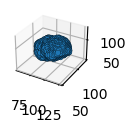

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plots


fig = plt.figure(figsize=(20,15))
rows = 3
cols = int(len(df_dict)/rows)
gs = gridspec.GridSpec(rows, cols, wspace=0.0005, hspace=0.0005)

# for ind in range(len(df_dict.keys())):
ind = 0 
for identifier, df in df_dict.items():
    X = df
    rx,ry,rz = np.asarray(X['x']), np.asarray(X['y']), np.asarray(X['z'])
    indices = []
    for ct_ in range(len(X)):
        if X['Cluster_Labels'].iloc[ct_] == 1:
            indices.append(ct_)
    selected_rows = X.iloc[indices]
    
    
#     if ind== 19:
#         selected_rows[['x','y','z']].to_csv('pred_crystals_2000ps.xyz', sep='\t', header=None, index=None)

#         print(selected_rows[['Q6','Nc_6','disp','N_N']])

    x_slice, y_slice, z_slice = [rx[i] for i in indices], [ry[i] for i in indices],[rz[i] for i in indices]
    ax = fig.add_subplot(gs[ind//cols, ind%cols], projection='3d')
    ax.scatter(x_slice, y_slice, z_slice, s=15.0, linewidth=0.2, alpha=1.0,edgecolor='k');
    
    ax.view_init(elev=0, azim=90, roll=0)
    ax.text(10.0, 0.0, 60.0, f'{(ind+1)*100} ps', color='k', fontsize=10, fontweight='bold')
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.set_zlim(-60,60)
#     ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ind += 1
plt.savefig("crystal_Ox_cluster.png",dpi=400)
# plt.tight_layout()
plt.show()


In [ ]:
NAT = len(df_dict['50ps'])
NAT

In [ ]:
len(avg_Nc_per_cluster)

In [ ]:
n_atoms_per_cluster = np.asarray(n_atoms_per_cluster)
avg_disp_per_cluster = np.asarray(avg_disp_per_cluster)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=3.0
plt.rcParams['figure.figsize'] = 65,20
plt.rcParams['lines.markersize']=30.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'


left,bottom,width,height = 0.04,0.04,0.20,0.85
rect_one = [left, bottom, width, height]
rect_two= [left+width+0.08, bottom, width, height]            
rect_three= [left+2*width+0.13, bottom, width, height]            

one_plot = plt.axes(rect_one)
two_plot = plt.axes(rect_two)
three_plot = plt.axes(rect_three)


time_vals = np.linspace(0.05, 0.05*len(avg_Nc_per_cluster), len(avg_Nc_per_cluster))

one_plot.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,0]], marker='s', label='Crytsal-like', color='#ff7f0e')
one_plot.plot(time_vals,[i/NAT for i in ct_Nc_gt_10], marker='^', label='Nc>10', color='k')
one_twin = one_plot.twinx()
one_twin.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,1]], marker='o', label='Glass-like', color='#1f77b4')
# one_plot.plot(time_vals,ct_Nc_gt_10, marker='^',lw=0.0, color='red')
one_plot.set_xlabel('Time (in ns)')
one_plot.set_ylabel('Fraction of atoms')

two_plot.plot(time_vals,avg_disp_per_cluster[:,0], marker='s', label='Crystal-like')
two_plot.plot(time_vals,avg_disp_per_cluster[:,1], marker='o', label='Glass-like')
two_plot.set_xlabel('Time (in ns)')
two_plot.set_ylabel('$<disp>$')

three_plot.plot(time_vals,mean_Q6_snap, marker='s', color='c')
three_twin = three_plot.twinx()
three_twin.plot(time_vals,mean_Nc_snap, marker='^', color='m')

three_plot.set_xlabel('Time (in ns)')
three_plot.set_ylabel('Mean $Q_6$', color='c')
three_twin.set_ylabel('Mean $N_c$', color='m')
# three_plot.set_ylim(0.271,0.303)

one_plot.legend(loc='best')
one_twin.legend(loc='best')
one_twin.yaxis.set_tick_params(labelcolor='#1f77b4')  # Set the color to red
one_plot.yaxis.set_tick_params(labelcolor='#ff7f0e')  # Set the color to red
# one_plot.yticklabels(color='#1f77b4')
two_plot.legend()

# plt.savefig("f_time_evol.pdf",dpi=1500, bbox_inches="tight")
plt.savefig("f_time_evol.png",dpi=500, bbox_inches="tight")
plt.show()

In [7]:
np.savetxt("c_size_evol.txt", n_atoms_per_cluster, delimiter='\t', fmt='%d')